# 3D Edge Object Detection - Training Notebook

This notebook implements the training pipeline for a custom object detector (SSDLite with MobileNetV3 backbone) on a Pascal VOC-like dataset.


In [24]:
import random
import xml.etree.ElementTree as ET
from pathlib import Path
from functools import partial

import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import (
    SSDLite320_MobileNet_V3_Large_Weights,
    ssdlite320_mobilenet_v3_large,
)
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.ssdlite import SSDLiteHead
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Ensure deterministic behavior
torch.manual_seed(42)
random.seed(42)


In [25]:
# Configuration
VOC_ROOT = "finetuning_dataset" # Adjust this path to your dataset location
CLASS_NAME = "cube_rouge"
EPOCHS = 20
BATCH_SIZE = 8
LR = 1e-3
NUM_WORKERS = 2
OUT_PATH = "cube_ssdlite.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")


Using device: cuda


In [26]:
def _read_image_ids(imageset_txt: Path):
    with imageset_txt.open("r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]


def _ensure_train_val_splits(voc_root: Path, val_ratio=0.2, seed=42):
    """
    Create ImageSets/Main/train.txt and val.txt if missing.
    Uses all .xml files found in Annotations/.
    """
    main_dir = voc_root / "ImageSets" / "Main"
    main_dir.mkdir(parents=True, exist_ok=True)

    train_txt = main_dir / "train.txt"
    val_txt = main_dir / "val.txt"

    if train_txt.exists() and val_txt.exists():
        return

    ann_dir = voc_root / "Annotations"
    xmls = sorted([p.stem for p in ann_dir.glob("*.xml")])
    if not xmls:
        raise RuntimeError(f"No XML found in {ann_dir}")

    random.seed(seed)
    random.shuffle(xmls)
    n_val = max(1, int(len(xmls) * val_ratio))
    val_ids = xmls[:n_val]
    train_ids = xmls[n_val:]

    train_txt.write_text("\n".join(train_ids) + "\n", encoding="utf-8")
    val_txt.write_text("\n".join(val_ids) + "\n", encoding="utf-8")
    print(f"[split] train={len(train_ids)} val={len(val_ids)} written to {main_dir}")


In [27]:
class VOCCubeDataset(Dataset):
    """
    Reads a VOC-like dataset:
      voc_root/
        Annotations/*.xml
        JPEGImages/*.jpg|png
        ImageSets/Main/train.txt (list of ids without extension)
    """

    def __init__(self, voc_root: str, split: str, class_name: str = "cube_rouge"):
        self.voc_root = Path(voc_root)
        self.split = split
        self.class_name = class_name

        imageset = self.voc_root / "ImageSets" / "Main" / f"{split}.txt"
        if not imageset.exists():
            raise FileNotFoundError(f"Split file not found: {imageset}")

        self.ids = _read_image_ids(imageset)

        self.ann_dir = self.voc_root / "Annotations"
        self.img_dir = self.voc_root / "JPEGImages"

    def __len__(self):
        return len(self.ids)

    def _find_image_path(self, image_id: str) -> Path:
        # Try common extensions
        for ext in [".jpg", ".jpeg", ".png", ".bmp"]:
            p = self.img_dir / f"{image_id}{ext}"
            if p.exists():
                return p
        # fallback: search by prefix
        matches = list(self.img_dir.glob(f"{image_id}.*"))
        if matches:
            return matches[0]
        raise FileNotFoundError(
            f"Image not found for id={image_id} in {self.img_dir}"
        )

    def __getitem__(self, idx: int):
        image_id = self.ids[idx]
        xml_path = self.ann_dir / f"{image_id}.xml"
        img_path = self._find_image_path(image_id)

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        boxes = []
        labels = []

        # Parse Pascal VOC XML
        root = ET.parse(xml_path).getroot()
        for obj in root.findall("object"):
            name = obj.findtext("name", default="").strip()
            if name != self.class_name:
                continue

            bnd = obj.find("bndbox")
            xmin = float(bnd.findtext("xmin"))
            ymin = float(bnd.findtext("ymin"))
            xmax = float(bnd.findtext("xmax"))
            ymax = float(bnd.findtext("ymax"))

            # Safety clamp
            xmin = max(0.0, min(xmin, w - 1))
            ymin = max(0.0, min(ymin, h - 1))
            xmax = max(0.0, min(xmax, w - 1))
            ymax = max(0.0, min(ymax, h - 1))

            if xmax <= xmin or ymax <= ymin:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # 1 = cube (0 = background)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "iscrowd": torch.zeros((labels.shape[0],), dtype=torch.int64),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            if boxes.numel()
            else torch.zeros((0,), dtype=torch.float32),
        }

        # torchvision detection expects float tensors [0..1]
        img_t = torchvision.transforms.functional.to_tensor(img)
        return img_t, target


In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Prepare Data
voc_root = Path(VOC_ROOT)
_ensure_train_val_splits(voc_root, val_ratio=0.2, seed=42)

train_ds = VOCCubeDataset(str(voc_root), split="train", class_name=CLASS_NAME)
val_ds = VOCCubeDataset(str(voc_root), split="val", class_name=CLASS_NAME)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=(DEVICE.type == "cuda"),
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=(DEVICE.type == "cuda"),
)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")


Training samples: 2
Validation samples: 1


In [29]:
def build_model(num_classes=2):
    # SSDLite 320 (MobileNetV3 backbone)
    # Load COCO weights then replace head for num_classes=2
    weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
    model = ssdlite320_mobilenet_v3_large(weights=weights)
    
    # Fixed input size for ssdlite320
    size = (320, 320)

    # Retrieve real output channels from backbone
    out_channels = det_utils.retrieve_out_channels(model.backbone, size)

    # Anchors per feature-map
    num_anchors = model.anchor_generator.num_anchors_per_location()

    # Same norm_layer as used in ssdlite torchvision definition
    norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.03)

    # Replace complete head
    model.head = SSDLiteHead(out_channels, num_anchors, num_classes, norm_layer)
    
    return model

# 2 classes = background + cube
model = build_model(num_classes=2)
model.to(DEVICE)


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [30]:
def freeze_bn(module: nn.Module):
    # Set all BatchNorm to eval mode (uses running_mean/var, does not update)
    if isinstance(module, nn.modules.batchnorm._BatchNorm):
        module.eval()

def train_one_epoch(model, optimizer, loader, device, epoch, print_every=50):
    model.train()
    model.apply(freeze_bn)  # <-- important
    total = 0.0

    for step, (images, targets) in enumerate(loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total += loss.item()
        if (step + 1) % print_every == 0:
            print(
                f"[epoch {epoch}] step {step + 1}/{len(loader)} loss={loss.item():.4f} "
                + " ".join([f"{k}={v.item():.3f}" for k, v in loss_dict.items()])
            )

    return total / max(1, len(loader))

@torch.no_grad()
def evaluate_loss(model, loader, device):
    model.train()  # keep train() so loss is calculated
    model.apply(freeze_bn)
    total = 0.0
    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        total += sum(loss_dict.values()).item()
    return total / max(1, len(loader))


In [31]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=max(1, EPOCHS // 3), gamma=0.2
)

best_val = float("inf")

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    tr = train_one_epoch(
        model, optimizer, train_loader, DEVICE, epoch, print_every=10
    )
    vl = evaluate_loss(model, val_loader, DEVICE)
    scheduler.step()

    print(f"[epoch {epoch}] train_loss={tr:.4f} val_loss={vl:.4f}")

    if vl < best_val:
        best_val = vl
        torch.save(
            {
                "model": model.state_dict(),
                "class_name": CLASS_NAME,
                "num_classes": 2,
            },
            OUT_PATH,
        )
        print(
            f"[save] best model saved: {OUT_PATH} (val_loss={best_val:.4f})"
        )


Starting training...
[epoch 1] train_loss=5.4899 val_loss=5.8907
[save] best model saved: cube_ssdlite.pth (val_loss=5.8907)
[epoch 2] train_loss=5.4374 val_loss=5.8925
[epoch 3] train_loss=5.3497 val_loss=5.9017
[epoch 4] train_loss=5.2370 val_loss=5.8923
[epoch 5] train_loss=4.9206 val_loss=5.8816
[save] best model saved: cube_ssdlite.pth (val_loss=5.8816)
[epoch 6] train_loss=4.4968 val_loss=5.8744
[save] best model saved: cube_ssdlite.pth (val_loss=5.8744)
[epoch 7] train_loss=3.9319 val_loss=5.8663
[save] best model saved: cube_ssdlite.pth (val_loss=5.8663)
[epoch 8] train_loss=3.7785 val_loss=5.8594
[save] best model saved: cube_ssdlite.pth (val_loss=5.8594)
[epoch 9] train_loss=3.6208 val_loss=5.8570
[save] best model saved: cube_ssdlite.pth (val_loss=5.8570)
[epoch 10] train_loss=3.4751 val_loss=5.8591
[epoch 11] train_loss=3.3478 val_loss=5.8659
[epoch 12] train_loss=3.2276 val_loss=5.8718
[epoch 13] train_loss=3.1124 val_loss=5.8728
[epoch 14] train_loss=3.0877 val_loss=5.873

## Inference and Visualization


Testing on: finetuning_dataset/JPEGImages/20251209_191116.jpg


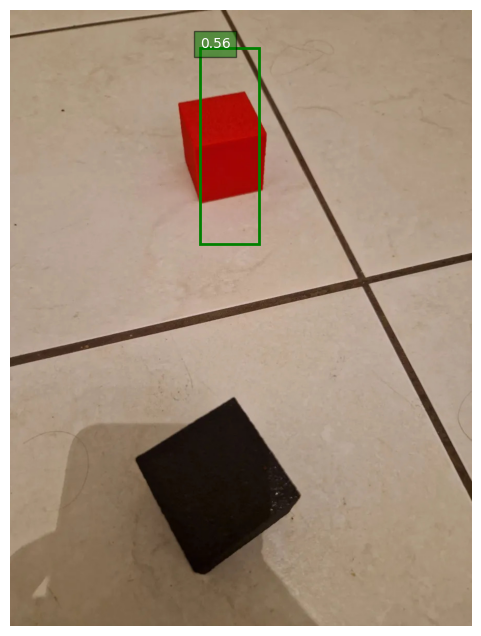

In [32]:
# Load the best model
ckpt = torch.load(OUT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.to(DEVICE)
model.eval()

# Inference settings
score_thr = 0.55
topk = 10

# Find a test image (take one from validation set or specify path)
# img_path = "finetuning_dataset/JPEGImages/20251209_190950.jpg" 
# If that specific image doesn't exist, let's pick one from the validation set
if len(val_ds) > 0:
    img_id = val_ds.ids[0]
    img_path = val_ds._find_image_path(img_id)
else:
    print("No validation images found.")
    img_path = None

if img_path:
    print(f"Testing on: {img_path}")
    
    # Preprocess
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = torchvision.transforms.functional.to_tensor(pil_img).to(DEVICE)

    with torch.no_grad():
        pred = model([img_tensor])[0]

    boxes = pred["boxes"].detach().cpu().numpy()
    scores = pred["scores"].detach().cpu().numpy()

    # Filter + topk
    idx = np.where(scores >= score_thr)[0]
    idx = idx[np.argsort(-scores[idx])][:topk]

    # Visualization using Matplotlib
    plt.figure(figsize=(12, 8))
    np_img = np.array(pil_img)
    plt.imshow(np_img)
    ax = plt.gca()

    for i in idx:
        x1, y1, x2, y2 = boxes[i]
        w = x2 - x1
        h = y2 - y1
        
        rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{scores[i]:.2f}", bbox=dict(facecolor='green', alpha=0.5), color='white', fontsize=10)

    plt.axis('off')
    plt.show()
else:
    print("Skipping inference as no image was found.")
